In [ ]:
#### merging datasets from pilot0 (N=19) and pilot1 (N=81)

In [2]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

from helpers import *
from analysis_helpers import *
import analysis_helpers as h
reload(h)

import ast


In [3]:
# directory & file hierarchy
exp_path = '3dObjects/sketchpad_basic'
analysis_dir = os.getcwd()
data_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','data',exp_path))
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','experiments',exp_path))
sketch_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','analysis',exp_path,'sketches','pilot1'))

In [5]:
D0 = pd.read_csv(os.path.join(os.path.join(analysis_dir,'sketchpad_basic_pilot0_group_data.csv')))
D1 = pd.read_csv(os.path.join(os.path.join(analysis_dir,'sketchpad_basic_pilot1_group_data.csv')))

In [6]:
_D = pd.concat([D0,D1], join="inner",ignore_index=True)

In [7]:
## get list of all valid gameids across session
_valid_p0 = np.unique(_D[_D['iteration']=='pilot0']['gameID'].values)

## 10/1/17: discussion with @rxdh: flag/exclude a game where the sketcher annotated drawing with words on at least two of the trials
wordy = ['4196-e2f9bf3f-e1cf-4e54-8188-f5f3d07f171b']
valid_p0 = [i for i in _valid_p0 if i not in wordy]
tmp = pd.read_csv('valid_gameids_pilot1.csv')
valid_p1 = np.unique(tmp['valid_gameids'].values)
valid_gameids = list(valid_p0) + list(valid_p1)
print '# valid games: ' + str(len(valid_gameids))

# valid games: 100


In [8]:
# filter so that only valid gameid's are included in the final merged group data csv
D = _D[_D['gameID'].isin(valid_gameids)]

In [9]:
## add another cost-related dependent measure: mean pixel intensity (amount of ink spilled) -- to handle
## some weird glitches in the num stroke count
mean_intensity = []
imsize = 100
numpix = imsize**2
thresh = 250
for i,_d in D.iterrows():
    imgData = _d['png']
    filestr = base64.b64decode(imgData)
    fname = os.path.join('sketch.png')
    with open(fname, "wb") as fh:
        fh.write(imgData.decode('base64'))
    im = Image.open(fname).resize((imsize,imsize))
    _im = np.array(im)
    mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)

In [10]:
# add mean_intensity to the main D dataframe 
### btw: mean_intensity and numStrokes is about 0.43 spearman correlated.
D = D.assign(mean_intensity=pd.Series(mean_intensity).values)
print stats.spearmanr(D['mean_intensity'].values,D['numStrokes'].values)

category = [h.objcat[t] for t in D.target.values]
D = D.assign(category=pd.Series(category).values)


SpearmanrResult(correlation=0.42679706498610881, pvalue=7.5674239508325116e-142)


In [11]:
# save out to merged group data csv
D.to_csv('sketchpad_basic_merged_group_data.csv')

### Print out all sketches from both pilot0 and pilot1 in same way


In [134]:
## print out sketches with target & distractors from this game in separate folders
import traceback
backup_path_images = '/Users/judithfan/Dropbox/stimuli_repository/subordinate_allrotations_6_minified'

_valid_gameids = valid_gameids[:3]

## get list of all incorrect sketch path names
incorrect_trial_paths = []

target_sketch_dir = os.path.join(analysis_dir,'sketches','sketch')
target_3D_dir = os.path.join(analysis_dir,'sketches','target')
distractor1_3D_dir = os.path.join(analysis_dir,'sketches','distractor1')
distractor2_3D_dir = os.path.join(analysis_dir,'sketches','distractor2')
distractor3_3D_dir = os.path.join(analysis_dir,'sketches','distractor3')
out_paths = [target_3D_dir,distractor1_3D_dir,distractor2_3D_dir,distractor3_3D_dir]


if not os.path.exists(target_3D_dir):
    os.makedirs(os.path.join(analysis_dir,'sketches','target'))
    os.makedirs(os.path.join(analysis_dir,'sketches','distractor1'))
    os.makedirs(os.path.join(analysis_dir,'sketches','distractor2'))
    os.makedirs(os.path.join(analysis_dir,'sketches','distractor3'))
    os.makedirs(os.path.join(analysis_dir,'sketches','sketch'))    

run_this = 0
if run_this:
    for g in valid_gameids:
        print 'Printing out sketches from game: ' + g
        _D = D[(D.gameID==g)]
        _D = _D.sort_values(by=['target'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(16,6))        
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            if not os.path.exists(target_sketch_dir):
                os.makedirs(target_sketch_dir)
            fname = os.path.join(target_sketch_dir,'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '.png')
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            im = Image.open(fname)
            im.save(fname)
            
            if _d['outcome']==0:
                incorrect_trial_paths.append('gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '.png')            

            targetname = _d['target']
            distractors = [_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]
            full_list = [_d['target'],_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]         
            
            for (i,d) in enumerate(full_list):
                if os.path.exists(backup_path_images):
                    if not np.isnan(_d['pose']):
                        pose = _d['pose']
                        fn = os.path.join(backup_path_images,get_actual_pose(d,pose)[0])
                    else:
                        fn = os.path.join(backup_path_images,get_actual_pose(d,35)[0])
                else:
                    if hasattr(_d, 'pose'):
                        pose = _d['pose']
                        URL = build_url_from_filenames(get_actual_pose(d,pose)[0])
                    else:
                        URL = full_dict[d]
                    fn = cStringIO.StringIO(urllib.urlopen(URL).read())
                fig = plt.figure(figsize=(8,8))                    
                im = Image.open(fn)
                im = im.resize((256,256), Image.ANTIALIAS).convert('RGB')                                
                out_dirs = [target_3D_dir,distractor1_3D_dir,distractor2_3D_dir,distractor3_3D_dir]                
                out_path = os.path.join(out_dirs[i],'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '.png')
                im.save(out_path)


In [ ]:
## save out number of incorrect trial paths
print "Number of incorrect trial paths: {}".format(str(len(incorrect_trial_paths)))
with open('incorrect_trial_paths.txt', 'w') as f:
    for path in incorrect_trial_paths:
        f.write(path + '\n')

In [76]:
### only consider correct trials

In [314]:
further_strokes, closer_strokes, further_svgLength, closer_svgLength,\
further_svgStd, closer_svgStd, further_svgLengthPS, closer_svgLengthPS, \
further_drawDuration, closer_drawDuration, further_accuracy, closer_accuracy, \
further_pixelintensity, closer_pixelintensity = h.get_summary_stats(D,valid_gameids, correct_only=True)

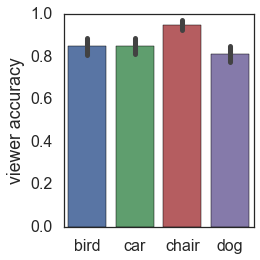

In [481]:
## checking for accuracy in close condition broken down by category
bird_accuracy, car_accuracy, chair_accuracy, dog_accuracy = h.get_close_accuracy_by_category(D,valid_gameids)
acc = pd.DataFrame([bird_accuracy,car_accuracy,chair_accuracy,dog_accuracy])
acc = acc.transpose()
acc.columns = ['bird','car','chair','dog']
plt.figure(figsize=(4,4))
sns.barplot(data=acc)
plt.ylabel('viewer accuracy')

### Plots, etc.

In [386]:
# destination for plots
plot_save_dir = './plots'

# aesthetic settings
marker_color = (0.4,0.7,0.4)
marker_size = 100
alpha_val = 0.5


In [387]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [388]:
sns.set_style('white')

fig = plt.figure(figsize=(8,6))
lb = 0
ub = 25
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_strokes,further_strokes,marker_size,marker_color,edgecolors='none',alpha=alpha_val)
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('close')
plt.ylabel('far')
plt.savefig(os.path.join(plot_save_dir,'scatter_num_strokes.pdf'))
plt.close()

fig = plt.figure(figsize=(8,6))
lb = 0
ub = 0.12
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_pixelintensity,further_pixelintensity,marker_size,marker_color,edgecolors='none',alpha=alpha_val)
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('mean pixel intensity')
plt.xlabel('close')
plt.ylabel('far')
plt.savefig(os.path.join(plot_save_dir,'scatter_pixel_intensity.pdf'))
plt.close()

## note: only correct trials are included to compute these stats, EXCEPT for the accuracy plot. 
fig = plt.figure(figsize=(8,4))
lb = 0
ub = 1.03
plt.subplot(1,2,1)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_accuracy,further_accuracy,marker_size,marker_color,edgecolors='none',alpha=alpha_val)
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('accuracy')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(1,2,2)
lb = 0
ub = 60
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_drawDuration,further_drawDuration,marker_size,marker_color,edgecolors='none',alpha=alpha_val)
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('draw duration (sec)')
plt.xlabel('closer')
plt.ylabel('further')
plt.tight_layout()
save_out = 1
plt.savefig('plots/scatter_performance.pdf')
plt.close()

In [376]:
numStrokes = pd.DataFrame(np.vstack((closer_strokes,further_strokes)).transpose(), \
                 columns = ['close','far'])
diffStrokes = pd.DataFrame((further_strokes-closer_strokes).transpose(), \
                 columns = ['far - close'])
pixIntensity = pd.DataFrame(np.vstack((closer_pixelintensity,further_pixelintensity)).transpose(), \
                 columns = ['close','far'])
diffPix = pd.DataFrame((further_pixelintensity-closer_pixelintensity).transpose(), \
                 columns = ['far - close'])
accuracy = pd.DataFrame(np.vstack((closer_accuracy,further_accuracy)).transpose(), \
                 columns = ['close','far'])
drawDuration = pd.DataFrame(np.vstack((closer_drawDuration,further_drawDuration)).transpose(), \
                 columns = ['close','far'])

In [383]:
# bar aesthetics
my_palette = sns.diverging_palette(200, 20, n=8)
my_palette = sns.cubehelix_palette(8)
my_palette = sns.color_palette("RdBu", n_colors=5)
my_palette = sns.cubehelix_palette(5, start=.5, rot=-.75)

In [384]:
sns.set_context('poster')
sns.set_style('white')

fig = plt.figure(figsize=(5,5))
sns.barplot(data=pixIntensity,ci=95,palette=my_palette)
plt.title('mean pixel intensity')
h = plt.yticks(np.arange(0,0.08,0.01))
plt.savefig('plots/bar_pixel_intensity.pdf')
plt.close()

fig = plt.figure(figsize=(5,5))
sns.barplot(data=numStrokes,ci=95,palette=my_palette)
plt.title('number of strokes')
plt.savefig('plots/bar_num_strokes.pdf')
plt.close()

fig = plt.figure(figsize=(3,7))
sns.barplot(data=diffStrokes,ci=95,palette=my_palette)
plt.ylabel(r'$\Delta$ num strokes (far - close)')
plt.ylim([-4,2])
plt.savefig('plots/bar_diff_strokes.pdf')
plt.tight_layout()
plt.close()

fig = plt.figure(figsize=(3,7))
sns.barplot(data=diffPix,ci=95,palette=my_palette)
plt.ylabel(r'$\Delta$ pixel intensity (far - close)')
plt.ylim([-0.018,0.005])
plt.savefig('plots/bar_diff_intensity.pdf')
plt.tight_layout()
plt.close()

fig = plt.figure(figsize=(5,5))
sns.barplot(data=accuracy,ci=95,palette=my_palette)
plt.title('accuracy')
plt.ylim([0,1.03])
plt.savefig('plots/bar_accuracy.pdf')
plt.close()

fig = plt.figure(figsize=(5,5))
sns.barplot(data=drawDuration,ci=95,palette=my_palette)
plt.title('draw duration')
plt.savefig('plots/bar_draw_duration.pdf')
plt.close()

In [390]:
np.shape(_D)

(1600, 20)

In [410]:
## length of stroke across stroke number
__D = D[D['numStrokes']<500]
_D = __D[__D['condition']=='closer']
num_trials = np.shape(_D)[0]
max_length = 50
CNum_curves = np.empty((num_trials,max_length,))
CNum_curves[:] = np.NAN
for i in np.arange(num_trials):
    svgs = ast.literal_eval(_D.iloc[i]['svg'])
    ns = len(svgs)
    num_curves = [len([m.start() for m in re.finditer('c', s)]) for s in svgs]
    if num_curves > max_length:
        num_curves = num_curves[:max_length]
    CNum_curves[i,:len(num_curves)] = num_curves

_D = __D[__D['condition']=='further']
num_trials = np.shape(_D)[0]
max_length = 50
FNum_curves = np.empty((num_trials,max_length,))
FNum_curves[:] = np.NAN
for i in np.arange(num_trials):
    svgs = ast.literal_eval(_D.iloc[i]['svg'])
    ns = len(svgs)
    num_curves = [len([m.start() for m in re.finditer('c', s)]) for s in svgs]
    if num_curves > max_length:
        num_curves = num_curves[:max_length]
    FNum_curves[i,:len(num_curves)] = num_curves    

# plot and save out    
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
marker_color = (0.4,0.8,0.4)
marker_color2 = (0.2,0.5,0.2)
plt.plot(np.nanmean(CNum_curves,axis=0),color=(marker_color), label='close')
plt.plot(np.nanmean(FNum_curves,axis=0),color=(marker_color2), label='far')
plt.legend(loc='upper right')
plt.ylabel('number of spline segments')
plt.xlabel('stroke number')
plt.savefig('plots/line_spline_segs_by_stroke.pdf')
plt.close()    

## Visualize distances

In [169]:
D = pd.read_csv('sketchpad_basic_merged_group_data.csv')

# filter so only looking at pilot1 because we have pose information on those games
D = D[D.iteration=='pilot1']

# filter out incorrect and invalid trials as well
incorrects = pd.read_csv('./incorrect_trial_paths.txt',header=None)[0].values
invalids = pd.read_csv('./invalid_trial_paths.txt',header=None)[0].values
fname = []
for i,j in zip(D['gameID'].values,D['trialNum']):
    fname.append('gameID_' + i + '_trial_' + str(j) + '.png')
D = D.assign(fname=pd.Series(fname).values)  
D = D[~D['fname'].isin(incorrects)]
D = D[~D['fname'].isin(invalids)]
print str(np.shape(D)[0]) + ' records in merged dataframe'

2361 records in merged dataframe


In [170]:
path_to_dists = './RSA/refModule/json/strict-similarity-pragmatics-conv4_2.json'
dists = pd.read_json('./RSA/refModule/json/strict-similarity-pragmatics-conv4_2.json')
dists = dists.transpose()

In [171]:
sketch_label = [(i[-12:] + '_' + str(j)) for i,j in zip(D['gameID'].values,D['trialNum'].values)]
D = D.assign(sketch_label=pd.Series(sketch_label).values)

In [172]:
all_dist_labels = dists.columns.values

In [173]:
dT = []
dD1 = []
dD2 = []
dD3 = []
for i, _d in D.iterrows():
    sketch = _d['sketch_label']
    pose = int(_d['pose'])
    target = _d['target'] + '_' + '{:04d}'.format(pose)
    distractor1 = _d['Distractor1'] + '_' + '{:04d}'.format(pose)
    distractor2 = _d['Distractor2'] + '_' + '{:04d}'.format(pose)
    distractor3 = _d['Distractor3'] + '_' + '{:04d}'.format(pose)
    dT.append(dists[sketch][target])
    dD1.append(dists[sketch][distractor1])
    dD2.append(dists[sketch][distractor2])
    dD3.append(dists[sketch][distractor3])

In [174]:
D = D.assign(dT=pd.Series(dT).values)
D = D.assign(dD1=pd.Series(dD1).values)
D = D.assign(dD2=pd.Series(dD2).values)
D = D.assign(dD3=pd.Series(dD3).values)

179


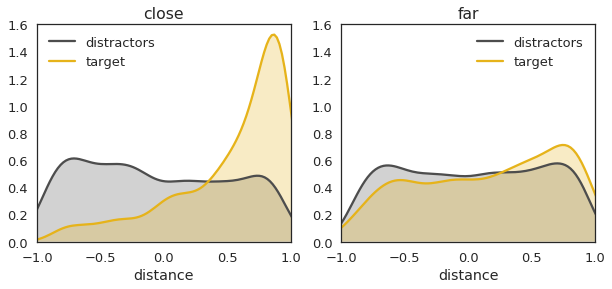

In [193]:
sns.set_context('talk')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
_D = D[D.condition=='closer']
distractor_dists = np.hstack((_D.dD1.values,_D.dD2.values,_D.dD3.values))
sns.kdeplot(distractor_dists, shade=True, color=(0.3,0.3,0.3),label='distractors')
sns.kdeplot(_D.dT.values, shade=True, color=(0.9,0.7,0.1),label='target')
plt.ylim([0,1.6])
plt.xlim([-1,1])
plt.xlabel('distance')
plt.title('close')

plt.subplot(1,2,2)
_D = D[D.condition=='further']
distractor_dists = np.hstack((_D.dD1.values,_D.dD2.values,_D.dD3.values))
sns.kdeplot(distractor_dists, shade=True, color=(0.3,0.3,0.3),label='distractors')
sns.kdeplot(_D.dT.values, shade=True, color=(0.9,0.7,0.1),label='target')
plt.ylim([0,1.6])
plt.xlim([-1,1])
plt.xlabel('distance')
plt.title('far')

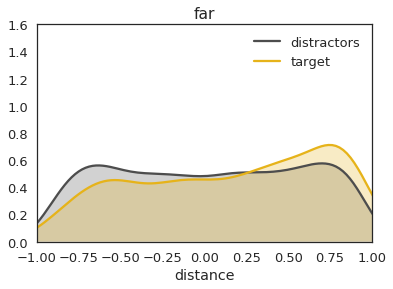

## Model comparison


In [546]:
def sumlogprob(a,b):
    if (a > b):
        return a + np.log1p(np.exp(b-a))
    else:
        return b + np.log1p(np.exp(a-b))    

#####  all data

(5700, 7)
                               logLikelihood
similarityMetric speakerModel               
early            S0            -20070.780666
                 S1            -20135.819904
nonstrict-high   S0            -19278.330040
                 S1            -19769.883752
strict-mid       S0            -19327.824007
                 S1            -19948.169317


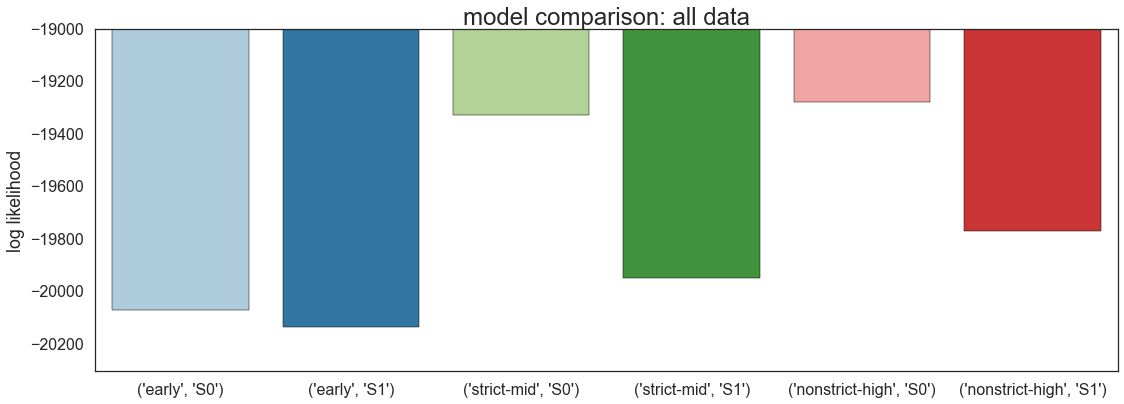

In [594]:
P = pd.read_csv('./RSA/bdaOutput/testingParams_alldata.csv')
# filter out rows where posterior probability is -Infinity
# P = P[P.posteriorProb!='-Infinity']
print np.shape(P)

X = P.groupby(['similarityMetric', 'speakerModel'])['logLikelihood']
Y = X.apply(lambda x: reduce(sumlogprob,x) - np.log(len(x)))
Y = pd.DataFrame(Y)

sns.set_context('poster')
colors = sns.color_palette("Paired")
fig = plt.figure(figsize=(16,6))
seq = [('early','S0'),('early','S1'),('strict-mid','S0'),('strict-mid','S1'),('nonstrict-high','S0'),('nonstrict-high','S1')]
sns.barplot(data=Y.transpose(),palette=colors, order = seq)
plt.ylim([-20300,-19000])
plt.ylabel('log likelihood')
plt.title('model comparison: all data',fontsize=24)

In [595]:
Y

logLikelihood
similarityMetric speakerModel               
early            S0            -20070.780666
                 S1            -20135.819904
nonstrict-high   S0            -19278.330040
                 S1            -19769.883752
strict-mid       S0            -19327.824007
                 S1            -19948.169317

#####  far only

(5700, 7)
                               logLikelihood
similarityMetric speakerModel               
early            S0            -10063.774307
                 S1             -9967.309122
nonstrict-high   S0             -9590.721470
                 S1             -9513.989966
strict-mid       S0             -9658.806560
                 S1             -9745.470731


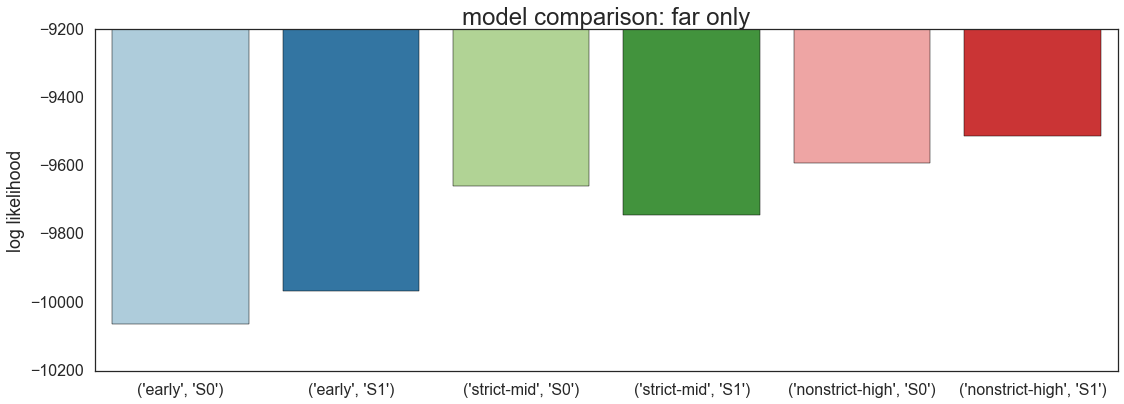

In [596]:
P = pd.read_csv('./RSA/bdaOutput/testingParams_faronly.csv')
# filter out rows where posterior probability is -Infinity
# P = P[P.posteriorProb!='-Infinity']
print np.shape(P)

X = P.groupby(['similarityMetric', 'speakerModel'])['logLikelihood']
Y = X.apply(lambda x: reduce(sumlogprob,x) - np.log(len(x)))
Y = pd.DataFrame(Y)
print Y
sns.set_context('poster')
colors = sns.color_palette("Paired")
fig = plt.figure(figsize=(16,6))
seq = [('early','S0'),('early','S1'),('strict-mid','S0'),('strict-mid','S1'),('nonstrict-high','S0'),('nonstrict-high','S1')]
sns.barplot(data=Y.transpose(),palette=colors, order = seq)
plt.ylim([-10200,-9200])
plt.ylabel('log likelihood')
plt.title('model comparison: far only',fontsize=24)

In [597]:
Y

logLikelihood
similarityMetric speakerModel               
early            S0            -10063.774307
                 S1             -9967.309122
nonstrict-high   S0             -9590.721470
                 S1             -9513.989966
strict-mid       S0             -9658.806560
                 S1             -9745.470731

In [ ]:
P.sort_values([''])